In [1]:
import gc
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
from tabulate import tabulate
import re
from hazm import Normalizer, word_tokenize, stopwords_list, Stemmer
import emoji

from googletrans import Translator

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, BertConfig, TFAutoModel

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
import tensorflow.keras.layers as Layers
import keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


d:\Python\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# CUDA

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Read Datasets and Shuffle

In [3]:
train = pd.read_csv('../data/digikala-reviews/original.csv')
test = pd.read_csv('../data/digikala-reviews/test.csv')


In [4]:
train.loc[len(train)] = [train.columns[0], int(train.columns[1])] 
train = train.set_axis(['text', 'label'], axis=1)


test.loc[len(test)] = [test.columns[0], int(test.columns[1])] 
test = test.set_axis(['text', 'label'], axis=1)

In [5]:
train['label']= train['label'].apply(lambda x: -1 if(x < 0) else 1 if (x > 0) else 0)
test['label']= test['label'].apply(lambda x: -1 if(x < 0) else 1 if (x > 0) else 0)

In [6]:
NUMCLASS = 3

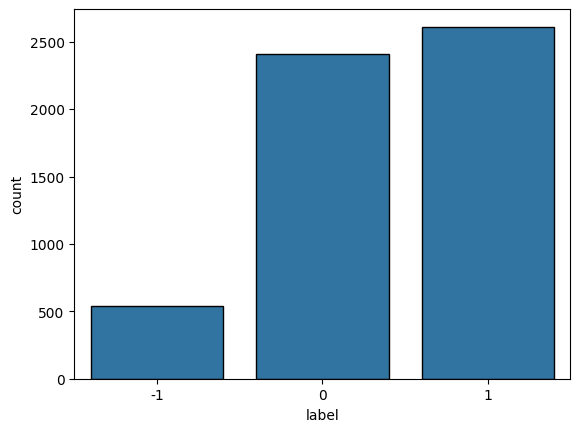

In [7]:
sea.countplot(train, x = 'label', edgecolor ='black')
plt.show()

# Preparing Data

## Preprocess

In [8]:
def preprocess(x, html = False, url = False, username = False, hashtag = False, rep = False, 
			   stopword = False, punctuation = False, demojize = True, stemming = False):

	if(html):
		x = re.sub(re.compile('<.*?>') , '', x)
	if(url):
		x = re.sub(r'http\S+|www\S+', '', x)
	if(username):
		x = re.sub(r'@[^ ]+', '', x)
	if(hashtag):
		x = re.sub(r'#', '', x)
	if(rep):
		x = re.sub(r'(.)\1+', r'\1', x)
	if(demojize):
		x = emoji.demojize(x, language='fa')
	if(punctuation):
		puncs = [
			'[', '!', '"', '#', '%', '\\', '\"', '(', ')', '*',
			'+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', 
			'/', '^', '_', '`', '{', '|', '}', '~',
			'’', '”', '“', '′', '‘', ']','؟','؛','«','»','،','٪'
		]
		pattern = r'[' + re.escape(''.join(puncs)) + r']'
		x = re.sub(pattern, ' ', x)

	tokens = word_tokenize(x)
	
	if(stopword):
		stopwords = stopwords_list()
		tokens = [token for token in tokens if token not in stopwords]
	if(stemming):
		stemmer = Stemmer()
		tokens = [stemmer.stem(token) for token in tokens]

	x = ' '.join(tokens)
	x = x.replace("\u200c", " ")

	return x

In [9]:
train['clean'] = train['text'].apply(lambda x: preprocess(x))
test['clean'] = test['text'].apply(lambda x: preprocess(x))

## Create Validation Data

In [10]:
train, valid = train_test_split(train, test_size=0.1, random_state=999)

## Back Translation

In [31]:
translate = Translator().translate
def back_translate(text: str, lang: str, midlang: str, show_translate = False):
	t = translate(text, src=lang, dest=midlang).text
	if(show_translate):
		print(t)
	b = translate(t, src=midlang, dest=lang).text

	return b

In [37]:
i = 2
print(train['text'][i])
print(back_translate(train['text'][i], lang='fa', midlang='fr', show_tranqslate=True))

نهایتا،  یک دوربین VGA نیز برای انجام مکالمات تصویری در قسمت جلویی گوشی تعبیه گردیده است.
Enfin, une caméra VGA est également installée en façade du téléphone pour les appels vidéo.
در نهایت یک دوربین VGA نیز در جلوی گوشی برای مکالمات تصویری تعبیه شده است.


## Data Augmentation

In [42]:
backtranslated = []

In [65]:
len(backtranslated)

1420

In [ ]:
for i in tqdm(range(1274, 2000)):
	t = back_translate(train['text'][i], lang='fa', midlang='fr')
	backtranslated.append(t)

In [66]:
b = pd.DataFrame(columns=['back'])
b['back'] = backtranslated


In [67]:
b.to_csv('backtrans.csv')

## Load FaBert

In [11]:
bert_tokenizer = AutoTokenizer.from_pretrained('./fabert')
bert_model = TFAutoModel.from_pretrained('./fabert')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it

## Tokenize

In [12]:
MAXLEN = 128

In [13]:
def tokenize(texts, tokenizer, maxlen = MAXLEN):
	ids = []
	masks = []
	types = []
	for text in texts:
		o = tokenizer.encode_plus(
			text,
			add_special_tokens=True,
			max_length=maxlen,
			pad_to_max_length=True,
			truncation=True,
			return_tensors='tf',
			verbose=0
		)
		ids.append(o['input_ids'])
		masks.append(o['attention_mask'])
		types.append(o['token_type_ids'])

	return (
		np.array(ids).reshape(len(texts), maxlen),
		np.array(masks).reshape(len(texts), maxlen),
		np.array(types).reshape(len(texts), maxlen)
	)

In [26]:
encoder = OneHotEncoder(sparse_output=False)
def create_datasets(
		tokenizer, train, valid, test, batch_size, maxlen = MAXLEN
):

	train_tokens = tokenize(train['clean'], tokenizer, maxlen)
	valid_tokens = tokenize(valid['clean'], tokenizer, maxlen)
	test_tokens = tokenize(test['clean'], tokenizer, maxlen)


	ytrain = encoder.fit_transform(train['label'].values.reshape(-1, 1))
	yvalid = encoder.transform(valid['label'].values.reshape(-1, 1))

	train_dataset = tf.data.Dataset.from_tensor_slices((
		{'input_ids': train_tokens[0], 'attention_mask': train_tokens[1]},
		ytrain
	))
	train_dataset = train_dataset.shuffle(len(train['label'])).batch(batch_size)

	valid_dataset = tf.data.Dataset.from_tensor_slices((
		{'input_ids': valid_tokens[0], 'attention_mask': valid_tokens[1]},
		yvalid
	))
	valid_dataset = valid_dataset.shuffle(len(valid['label'])).batch(batch_size)

	test_dataset = tf.data.Dataset.from_tensor_slices((
		{'input_ids': test_tokens[0], 'attention_mask': test_tokens[1]}
	)).batch(batch_size)

	return train_dataset, valid_dataset, test_dataset

# Networks

## Utils

In [15]:
def show_model(model):
	model.summary()
	plot_model(
		model,
		show_shapes = True,
		show_dtype=False,
		show_layer_names = True,
		rankdir = 'TB',
		expand_nested = False,
		dpi = 256
	)

In [65]:
def training_metrics(history):

	epochs = range(1, len(history.history['loss']) + 1)

	plt.figure(figsize=(12, 6))
	plt.subplot(1, 2, 1)
	plt.plot(epochs, history.history['loss'], 'r-', label='Training Loss')
	plt.plot(epochs, history.history['val_loss'], 'b-', label='Validation Loss')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.legend()

	plt.subplot(1, 2, 2)
	plt.plot(epochs, history.history['accuracy'], 'r-', label='Training Accuracy')
	plt.plot(epochs, history.history['val_accuracy'], 'b-', label='Validation Accuracy')
	plt.xlabel('Epochs')
	plt.ylabel('Accuracy')
	plt.legend()


	plt.tight_layout()
	plt.show()

def test_metrics(y_true, y_pred, labels = [-1, 0, 1]):
	accuracy = accuracy_score(y_true, y_pred)
	precision = precision_score(y_true, y_pred, average=None, labels=labels)
	recall = recall_score(y_true, y_pred, average=None, labels=labels)
	f1 = f1_score(y_true, y_pred, average=None, labels=labels)

	precision_macro = precision_score(y_true, y_pred, average='macro')
	recall_macro = recall_score(y_true, y_pred, average='macro')
	f1_macro = f1_score(y_true, y_pred, average='macro')

	precision_micro = precision_score(y_true, y_pred, average='micro')
	recall_micro = recall_score(y_true, y_pred, average='micro')
	f1_micro = f1_score(y_true, y_pred, average='micro')

	precision_weighted = precision_score(y_true, y_pred, average='weighted')
	recall_weighted = recall_score(y_true, y_pred, average='weighted')
	f1_weighted = f1_score(y_true, y_pred, average='weighted')

	accuracy_table = [["Accuracy", f"{accuracy:.4f}"]]

	class_metrics = []
	for i in labels:
		class_metrics.append([f"Class {i}", f"{precision[i]:.4f}", f"{recall[i]:.4f}", f"{f1[i]:.4f}"])

	average_metrics = [
		["Macro average", f"{precision_macro:.4f}", f"{recall_macro:.4f}", f"{f1_macro:.4f}"],
		["Micro average", f"{precision_micro:.4f}", f"{recall_micro:.4f}", f"{f1_micro:.4f}"],
		["Weighted average", f"{precision_weighted:.4f}", f"{recall_weighted:.4f}", f"{f1_weighted:.4f}"]
	]

	print(tabulate(accuracy_table, headers=["Metric", "Value"], tablefmt="grid"))
	print(tabulate(class_metrics, headers=["Class", "Precision", "Recall", "F1-score"], tablefmt="grid"))
	print(tabulate(average_metrics, headers=["Average Type", "Precision", "Recall", "F1-score"], tablefmt="grid"))

	cm = confusion_matrix(y_true, y_pred, labels=labels)
	plt.figure(figsize=(8, 6))
	sea.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
	plt.title('Confusion Matrix')
	plt.xlabel('Predicted')
	plt.ylabel('True')
	plt.show()

In [17]:
def create_model(base_model):
	input_ids = Layers.Input(shape=(MAXLEN,), dtype=tf.int32, name="input_ids")
	attention_mask = Layers.Input(shape=(MAXLEN,), dtype=tf.int32, name="attention_mask")
	bert_output = base_model(input_ids, attention_mask=attention_mask)[1]
	dense_output = Layers.Dense(NUMCLASS, activation='softmax')(bert_output)
	model = Model(inputs=[input_ids, attention_mask], outputs=dense_output)

	
	bert_layers = bert_model.layers[0].encoder.layer
	bert_layers[-1].trainable = True
	for i in range(len(bert_layers) - 1):
		bert_layers[i].trainable = False
	return model

### 1. Train Data

In [18]:
model = create_model(bert_model)
show_model(model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  124441344   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [19]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
	loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
train_dataset, valid_dataset, Xtest = create_datasets(
    bert_tokenizer, 
    batch_size = 4,
    train = train,
    valid = valid,
    test = test
	)

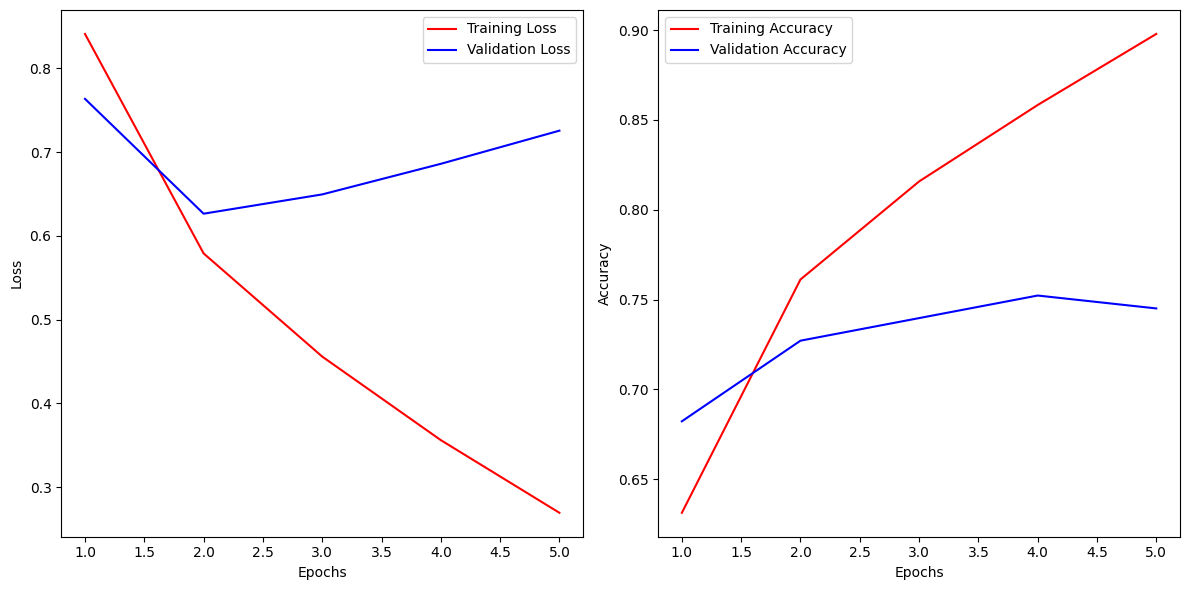

+----------+---------+
| Metric   |   Value |
+==========+=========+
| Accuracy |  0.7907 |
+----------+---------+
+----------+-------------+----------+------------+
| Class    |   Precision |   Recall |   F1-score |
+==========+=============+==========+============+
| Class -1 |      0.8611 |   0.8131 |     0.8364 |
+----------+-------------+----------+------------+
| Class 0  |      0.7122 |   0.5051 |     0.591  |
+----------+-------------+----------+------------+
| Class 1  |      0.7321 |   0.8385 |     0.7817 |
+----------+-------------+----------+------------+
+------------------+-------------+----------+------------+
| Average Type     |   Precision |   Recall |   F1-score |
+==================+=============+==========+============+
| Macro average    |      0.7685 |   0.7189 |     0.7364 |
+------------------+-------------+----------+------------+
| Micro average    |      0.7907 |   0.7907 |     0.7907 |
+------------------+-------------+----------+------------+
| Weighted av

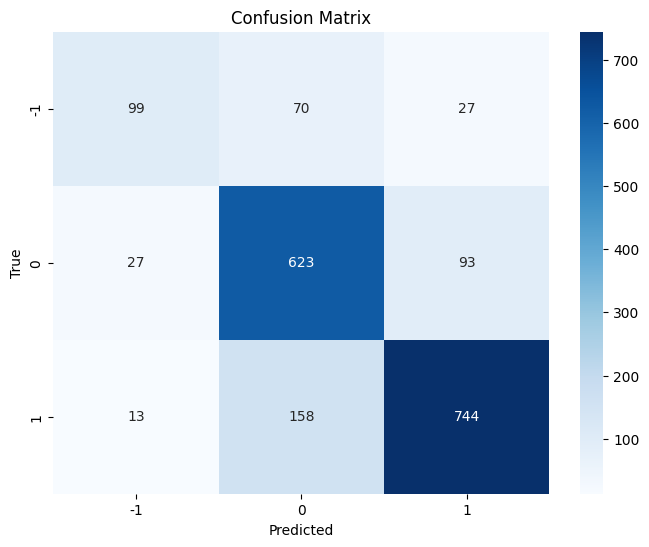

In [69]:
history = model.fit(train_dataset, epochs=5, validation_data=valid_dataset)

training_metrics(history)

y_pred = model.predict(Xtest)
y_pred = np.argmax(y_pred, axis=1) - 1
test_metrics(test['label'], y_pred)

### 2. Augmented Data